# Week 3 - Penalized Regression

**Outline**
- example of Lasso
- example of Ridge Regression
- example of Elastic Net
- Exercise
- Extra Resources

**Penalized Regression**

Linear regression problems can suffer from overfitting - with penalized regression being a main method for combating this problem. Additionally, using the MLE can generate large variabiliity (high beta variance) and a lack of intrepretability when the number of columns is large in respect to the number of rows. Comparing models using all possible subsets of predictors is prohibitively computationally expensive and highly unstable (the results can change drastically with small changes in the data).

Penalized regression performs automated feature selection to combat these issues. When using a lasso model, those predictors that are not important have their beta coefficients shrunk to zero. While the ridge regression and elastic net algorithms will shrink the less important coefficeints - though not all the way to zero. This reduces the complexity of the model (reducing overfitting) and often results in a more parsimonious model (a common goal of statistics). Note: if the actual relationship you are attempting to model is quite complex, these methods may not work and OLS should be compared with PLS (from your comp epi class) instead.

When training an algorithm, you want to choose the 'best' model for prediction - often by using a metric like Mean Squared Error (MSE). Linear regression uses OLS or MLE to find this optimal model (they give the same solution). OLS has proven to be the best linear unbiased estimator (see [wikipedia](https://en.wikipedia.org/wiki/Gauss%E2%80%93Markov_theorem) for the math if interested).


However, due to the bias-variance tradeoff, you can find a model with a lower MSE than the unbiased model (adding bias will decrease the MSE at first before increasing it as bias increases). 

![Bias Variance Tradeoff](BVTradeoff.png)

Penalized regression adds a penalty term to the OLS equation. This constrained optimization problem allows you to find the best biased model - which may outperform the unbiased model. Mathematically, this is equivalent to using a maximum a posteriori (MAP) estimator with a Gaussian prior (bayesian framework).


*Different types of penalized regression*

There are three types of penalized regression
1. Lasso - uses the L1 norm as a penalty term (absolute value)
2. Ridge Regression - uses the L2 norm as a penalty term (squared value)
3. Elastic Net - a weighted average of the L1 and L2 norms.

![Objective Functions](Equations.png)

Increasing $\lambda$ increases the bias. Decreasing $\lambda$ increases the variance. Bias is related with a model failing to fit the training set and variance is related with a model failing to fit the testing set. OLS models are always on the right side of the figure, having the lowest bias and the highest variance. It is fixed there, never moves, but we want to move it to the point of lowest error. (See 

![Beta Supression](LvsR.png)

As you can see, the shape of the L1 norm (blue square) allows the beta coefficient (red line) to get to 0 on the y axis. While the circular shape of the L2 allows the beta coefficient to get close to 0, but not all the way.

All penalized regression algorithms use a stochastic (random) component to perform feature selection. This means that if you run a model twice, you will likely get two different sets of results. To combat this, we use **stabiliity analysis** - where you compute a large number (like 100) of models and average the feature selection results. Some models will be more stable than others, but doing this step will allow you to make more confident conclusions about which variables are actually important to the model rather than being included in the significant result set by chance.


**Choosing your model**

In statistics or data science, you would want to justify your model selection. For example, Lasso is the best for reducing model complexity while a ridge regression or elastic net allow you to keep weak predictors in the model that may more accurately represent the real life phenomena. In machine learning, you want to use the model that gives you the best results. Note: Lasso can struggle with highly collinear predictors, where elastic net essentially creates groupings of said predictors (including the whole group if one of the members is selected for the model). You should still use test set accuracy to determine the optimal algoirithm, but if using lasso with highly correlated data, you should have less confidence in your feature importance conclusions than from an elastic net analysis.


**Model Limitations**

Lasso
- when p>n, lasso will select at most n predictors -- even if it should select more.
- If there are highly collinear variables, lasso will randomly select one of them. Elastic net and ridge regression models are less impacted by collinearity while PLs models (not covered here) account for the correlation structure in the predictors.

Ridge Regression
- while it reduces the complexity of the model by dampening beta coefficients, it does not perform variable selection/ feature reduction.
- if p>n, will still choose more than n predictors -- which could lead to bad predictions.

Elastic Net
- Also does not perform feature reduction.
- Typically reduces the complexity less than lasso but more than ridge regression. While this may seem like a Goldilocks solution, some phenomena may require the increased or decreased complexity found in the other algorithms.

**Cross Validation**


Cross validation is the best practice for tuning a model. It allows you to split your training data into n versions of training + validation data sets. You then build n models, averaging the performance metric of choice. In a one off tuning without a validation set, you may overfit the data or have selection bias present. Since you do not (ever!) use your test data to select your best performing model, you may accidentially choose an inferior model as the best one. Using the average performance of n different models trained on n different datasets will protect you from these sources of error and allow you to select the best tuning parameters.

![Cross Validation](CV.png)




## Data

We will be using [Colon Cancer Gene Expression Data](https://www.kaggle.com/masudur/colon-cancer-gene-expression-data) for the first penalized regression. A common omics study will try to identify which gene expressions are most important in the manifestation of a health outcome - such as colon cancer. This is a classification task for which penalized regression could be used. However, we are going to instead focus on a regression task using the dataset - which is made up of only colon cancer patients. As the gene H55933 has been found to be an important predictor in many studies ([For example](https://www.sciencedirect.com/science/article/pii/S1532046417300321) we will be looking to predict its value - a continuous outcome - from the other genes available in the dataset. This could be an important step in continuing the exploration of the path between your genes and prostate cancer.

The dataset has 62 observations and 2000 predictors. As this is clearly a p >> n problem, we will need to use penalized regression. 

**Cleaning the Data**

All of the predictors expect one are numeric. No data is missing and none of the other columns require any data type conversion. We will drop the class variable as it is not a gene.

**Scaling the data**

In order for the penalty term to have the same impact on each variable, the data must be scaled. Additionally, if you scale all of the numeric predictors, the magnitude of the betas now act a proxy for importance. With all the data on the same scale, higher betas mean higher importance.

We will be using the [StandardScaler function](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), which performs a z-transformation on each of the numeric values. 

$z = \frac{x - \mu}{\sigma}$

You fit the standardscaler object on the training data (getting the $\mu$ and $\sigma\$ values) and then use the fitted object to transform both the training and test data. It is important that you do not fit using the test data - even when you are going to transform the test set. If you do so, this is data leakage and will make it so that identical values will be different after the transformation. For example, 2 in the training set could end up at 1 while 2 in the test set could end up at 1.3.

**Note: While we are using a continuous response variable, penalized regression methods also work for categorical responses as well.**


In [2]:
## Importing packages

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold

from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import math

import matplotlib.pyplot as plt

import sklearn

import warnings

import numbers

In [27]:
## Functions


def get_reg_results(truth, prediction, df, idx):
    '''
    This function generates a results dataframe given your y_test and predictions. 
    It allows you to take the output of this function and put it into the next time you call the function
    Filling out the entirity of the dataframe one function call (and row) at a time
    Inputs:
    - truth = y_test, the actual values
    - prediction = your predictions
    - df = a dataframe that is already set up to hold our data. 
    - idx = the method that you are using (which corresponds to a row index)
    Output:
    - the input df, but with another row filled out
    '''
    
    mse_int = mean_squared_error(y_test, y_pred)
    mse = round(mse_int, 3)
    rmse = round(math.sqrt(mse_int), 3)
    mae = round(mean_absolute_error(y_test, y_pred), 3)
    
    SS_Residual = sum((truth-prediction)**2)       
    SS_Total = sum((truth-np.mean(truth))**2)     
    r_squared = 1 - (float(SS_Residual))/SS_Total
    
    r2 = round(r_squared, 3)
    
    df.loc[idx, :] = [mse, rmse, mae, r2]
    
    return df


def stab_analysis(X_train, y_train, alg = 'Lasso', ndisplay = 20, niter = 10, 
                  parameters = {'alpha':np.arange(0, 5, .1)}):
        
    '''
    This function performs a stabiliity analysis on the penalized regression method you choose.
    Stabiility analysis runs multiple iterations of the method selected 
    - averaging the beta estimates and showing the percent included for variables in a lasso
    Inputs:
    - X_train = your X training data
    - y_train = your y training data
    - alg = which algorithm you are choosing. Can be 'Lasso', 'Ridge', 'Elastic'
    - ndisplay = how many variables to display ini the resulting plots
    - niter = the number of iterations to run before calculating the percent included and average betas
    - parameter = the parameters to enter into the cross validation function
    -- these are the tuning parameters
    Output:
    - for all three algorithms, it plots the average beta for the top ndisplay variables
    - for lasso, it also has a plot of the percentage the top ndisplay variables are included
    '''
    
    results = pd.DataFrame(index = list(X_train.columns), columns = range(niter))
    
    for i in range(niter):

        if alg == 'Lasso':
            model = Lasso(random_state = i)
        elif alg == 'Ridge':
            model = Ridge(random_state = i)
        elif alg == 'Elastic':
            model = ElasticNet(random_state = i)
        else:
            print('Check your algorithm arguement')
        
        cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=i)
        clf = GridSearchCV(model, parameters, cv = cv, n_jobs=3, scoring = 'neg_root_mean_squared_error')
        clf.fit(X=X_train, y=y_train)
        lasso_model = clf.best_estimator_.fit(X=X_train, y=y_train)
        
        results.iloc[:,i] = lasso_model.coef_
        
    avg_results = pd.DataFrame(results.mean(axis = 1))
    
    avg_results.columns = ['Est']
    
    avg_results['abs_est'] = abs(avg_results['Est'])
    avg_results = avg_results.sort_values('abs_est', ascending= False)
    avg_results.drop('abs_est', inplace = True, axis = 1)
    
    ## Only the top n
    
    labs = list(X_train.columns)[:ndisplay]
    avg_results = avg_results.iloc[:ndisplay,:]

    fig = plt.figure(figsize = (15,10))
    ax = plt.subplot(111)
    ax.bar(range(avg_results.shape[0]), avg_results['Est'])
    ax.set_title('{} Average Variable Importance - Top 20'.format(alg))
    ax.set_ylabel('Beta Estimate')
    ax.set_xlabel('Variable')
    _ = plt.xticks(range(ndisplay), labels = labs, rotation = 60)
    plt.show()
    

    if alg == 'Lasso':

        perc_df = results != 0

        perc_df = pd.DataFrame(perc_df.sum(axis = 1) / perc_df.shape[1])
        perc_df.columns = ['Perc']
        perc_df = perc_df.sort_values('Perc', ascending = False)
        
        ## Only the top n
        
        labs = list(X_train.columns)[:ndisplay]
        perc_df = perc_df.iloc[:ndisplay,:]

        fig = plt.figure(figsize = (15,10))
        ax = plt.subplot(111)
        ax.bar(range(perc_df.shape[0]), perc_df['Perc'])
        ax.set_title('{} Percent Included'.format(alg))
        ax.set_ylabel('Percent Included')
        ax.set_xlabel('Variable')
        _ = plt.xticks(range(ndisplay), labels = labs, rotation = 60)
        plt.show()



In [ ]:
## Setting global parameters

parameters = {'alpha':np.arange(0.1, 5, .1)}
# for lasso and ridge

params = {'alpha':np.arange(0, 7, 0.1), 'l1_ratio': np.arange(0, 1, 0.1)}
# for elastic net

In [28]:
## Loading the data and dropping the data
data = pd.read_csv('colon.csv')
data.drop('Unnamed: 0', axis = 1, inplace = True)
data.drop('Class', axis = 1, inplace = True)

In [29]:
## Set the target
target = data['H55933']
data.drop('H55933', axis = 1, inplace = True)

In [30]:
data.shape

(62, 1999)

In [31]:
data.info()

# The dataset is too big to see what data types there are easily
## Lets look at just the non numeric ones

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Columns: 1999 entries, R39465 to T49647
dtypes: float64(1999)
memory usage: 968.4 KB


In [32]:
non_numeric = data.select_dtypes(exclude = ['float64'])
print(non_numeric)


Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]

[62 rows x 0 columns]


In [33]:
data.describe()

,R39465,R39465_,R85482,U14973,R02593,T51496,H80240,T65938,T55131,T72863,...,X67699,R70790,L11706,T90549,D17390,M33210,H18490,H40891,R77780,T49647
count,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,...,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000
mean,4966.959971,4094.727906,3987.789302,2937.126132,4705.119294,3588.800302,2872.288627,4680.191126,4039.661958,3399.386232,...,186.204532,100.227903,293.222722,124.653387,133.186935,184.136636,84.118387,114.930000,53.251230,42.965827
std,2188.890465,1818.080945,2019.086906,1356.932895,2400.848121,1872.106074,1122.365445,2417.239210,2018.044259,1841.232524,...,117.605889,78.022713,179.249194,75.535838,101.372557,159.914871,86.182028,88.011866,38.462814,28.395175
min,1383.488600,1269.648700,1186.030400,1166.553600,1087.750000,1062.697500,1026.477500,995.790000,974.815500,967.785000,...,5.950000,5.935000,5.925000,5.923750,5.916250,5.888095,5.878750,5.848750,5.842500,5.816250
25%,3408.951225,2763.725975,2648.942800,1890.857050,2843.368825,2112.952225,2050.814050,2971.792800,2797.992475,2262.145950,...,117.778870,48.409375,161.518125,69.121250,71.637500,85.905057,30.701875,53.881563,27.334375,24.610000
50%,4738.280500,3890.338150,3451.498150,2666.075700,4416.617650,3438.180000,2844.960650,4088.735500,3823.017800,2826.344350,...,152.722625,83.080625,251.883125,114.658125,104.271875,142.578565,56.385625,93.825625,45.358125,34.775000
75%,6455.843300,5008.993925,4738.408950,3563.969400,6076.031850,4420.645200,3414.228475,6171.382750,4840.715525,4452.665550,...,247.298513,117.208438,424.742500,177.730310,149.772188,212.019948,101.231250,145.074062,66.235312,54.697500
max,10152.273000,8605.044000,11248.680000,8093.875000,11222.682000,9939.246000,5917.026400,14144.835000,12307.913000,8021.137700,...,725.338100,438.383760,902.572500,333.418760,464.930000,702.130900,405.600000,390.890000,197.220000,126.826250


In [34]:
## Splitting the data

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25, random_state=42)
# Since the dataset is small, we are going to make a .25 test size to get more stable results



In [35]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train)
X_train.columns = data.columns
X_test = pd.DataFrame(X_test)
X_test.columns = data.columns

In [36]:
## Sanity check to make sure we didn't lose any data in the split

X_train.shape[0] + X_test.shape[0] == data.shape[0]

True

In [38]:
## Setting up a results dataframe
results = pd.DataFrame(index = ['Lasso'], columns = ['MSE', 'RMSE', 'MAE', 'R2'])

## Lasso

We will be using the lasso function from the scikit-learn package (abbreviated as sklearn). The [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) lets us known that the alpha, fit_intercept, and random_state parameters are important - with max_iter also being useful.

- *alpha* is the penalty term that is multiplied by the L1 norm. If alpha = 0, then the model is equivalent to a normal linear regression OLS. It defaults to 1. This is a parameter that you want to tune to find the best value for.

- *random_state* creates the psuedo-random numbers that the algorithm uses. It is important to always set a random state (like setting a seed in r) to ensure that your analysis is reproducable. 

- *max_iter* controls the number of iterations. You will sometimes get a warning message that your algorithm did not converge and may need more iterations. Some people choose to ignore this (most people ignore all warnings) while others will increase the max_iter parameter to avoid the warning.

**Cross Validation**

As mentioned above, we will use cross validation to tune the model parameter(s) - which is alpha here. [Grid Search CV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) is a great function to perform this with. It takes in an estimator (like Lasso), a grid of paramaters to test (here just a element dictionary of values for alpha), and the cross splitting strategy. We will use the [repeated kfold function](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedKFold.html) as our strategy - where we will set the number of folds in our cv, a random state, and the number of times to repeat the cv. Additionally, we will set the scoring function to be rmse as it is popular to use and reports values on the same scale as your outcome. 

*Note: n_jobs parameter in gridsearchcv is the number of jobs to run in parallel. -1 will use all the processors. I set it to 3 so that I can still run other scripts/programs on my computer if the model takes a long time to run. These won't, but a neural network can take 8+ hours*


**p >> n**

Since the dataset suffers from the p >> n problem, only the lasso penalized regression method is applicable. The other two methods will reduce the number of variables choosen until n == p, but we will still not have enough degrees of freedom to have robust and accurate results.

In [14]:
## Fitting the model and making predictions

model = Lasso(random_state = 4) #alpha will be adjusted in the gridsearch
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

clf = GridSearchCV(model, parameters, cv = cv, n_jobs=3, scoring = 'neg_root_mean_squared_error')
# remember parameters is set above as a global parameter

clf.fit(X=X_train, y=y_train)
lasso_model = clf.best_estimator_

print('The best alpha value is {}'.format(clf.best_params_['alpha']))

y_pred = lasso_model.predict(X_test)



The best alpha value is 2.2


/Users/thomas/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 252802.67711159872, tolerance: 52161.78027869937
  positive)


array([  0.       ,   0.       , 100.0935591, ...,   0.       ,
        -0.       ,  -0.       ])

In [39]:

results = get_reg_results(y_test, y_pred, results, 'Lasso')
results

,MSE,RMSE,MAE,R2
Lasso,570887,755.571,564.402,0.784


In [42]:
num_pred = sum(lasso_model.coef_ != 0)
print('The number of nonzero predictors is {}, reduced from {}'.format(num_pred, X_train.shape[1]))

The number of nonzero predictors is 69, reduced from 1999


#### R equivalent plots

The glmnet package in R has a few plotting functions built in (see below) that do not have an equivalent in python. These plots are mainly for diagnostic purposes and I would not display them in a final report or presentation (or even do them in my analysis). However, in case you do want to recreate them, the code below will do so. Rather than being able to use the gridsearchcv, you have to manually loop over the desired alpha values and store the results for plotting inputs. **Note: in R, you find the best lambda for your model - in python you find the best alpha. These are actually the same values, just named differently.**

![pr mse](error_plot.png)

![coef_shrinkage](reg_trace.png)

For plots I would present, see the stability analysis subsection below.

In [15]:
warnings.filterwarnings(action='ignore') # gives warnings about convergence that aren't important

## Creating the data to plot

lasso_reg = Lasso(alpha=0, random_state = 8)
lasso_reg.fit(X_train, y_train)
lasso_df = pd.DataFrame({'variable': list(X_train.columns), 'estimate': lasso_reg.coef_})
lasso_train_pred = []
lasso_test_pred = []

# iterate lambdas
for i,alpha in enumerate(np.arange(0, 5, .1)):
    # training
    lasso_mod = Lasso(alpha=alpha, random_state = i)
    lasso_mod.fit(X_train, y_train)
    var_name = 'estimate' + str(alpha)
    lasso_df[var_name] = lasso_mod.coef_
    lasso_train_pred.append(lasso_mod.predict(X_train))
    lasso_test_pred.append(lasso_mod.predict(X_test))
    

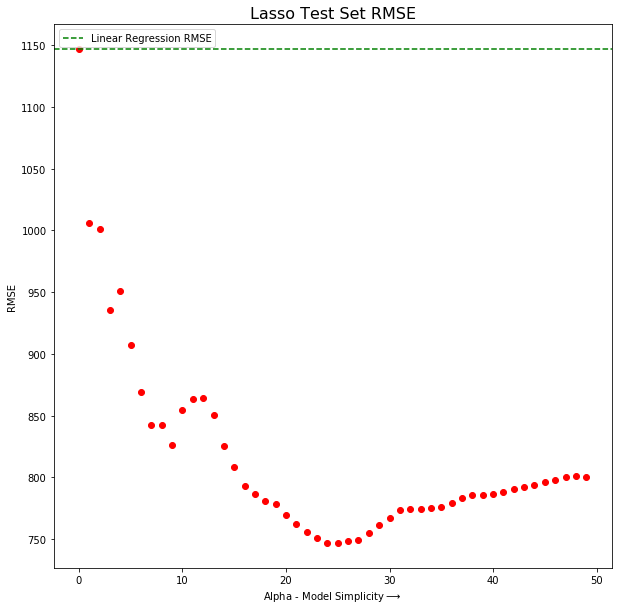

In [16]:
## Test MSE
xlabels = [round(x,2) for x in np.arange(0, 5, .1)]
lasso_mse_test = [np.sqrt(mean_squared_error(y_test, p)) for p in lasso_test_pred]
ols_pred = lasso_reg.predict(X_test)
ols_mse = np.sqrt(mean_squared_error(y_test, ols_pred))

# plot mse
plt.figure(figsize = (10,10))
plt.plot(lasso_mse_test, 'ro')
plt.axhline(y=ols_mse, color='g', linestyle='--', label = 'Linear Regression RMSE')
plt.title("Lasso Test Set RMSE", fontsize=16)
plt.xlabel("Alpha - Model Simplicity$\longrightarrow$")
plt.ylabel("RMSE")
_ = plt.legend(loc = 'upper left')

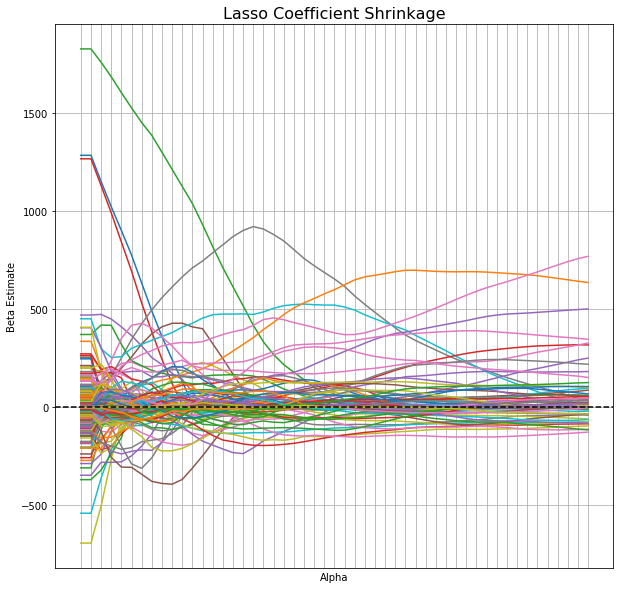

In [18]:
## Coefficient Shrinkage Plot

fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(lasso_df.T.iloc[1:, :])
ax.axhline(y=0, color='black', linestyle='--')
ax.set_xlabel("Alpha")
ax.set_ylabel("Beta Estimate")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.set_title("Lasso Coefficient Shrinkage", fontsize=16)
ax.grid(True)

**Looking at the plots**

From the MSE plot, we can see that adding bias to the model and reducing the complexity does improve model considerably.

From the shrinkage plot, we can expect that while there are a large amount of significant predictors, there is a large cluster of 0 beta values.

#### Stability Analysis

There is no prebuilt stability analysis function for penalized regression analysis, so we will make our own - found in the functions section at the top of the notebook. To do so, we will create the same model as above n times while storing the beta coefficients from each model. We will then average the coefficients across the model - giving their average importance. For this lasso section only, we will also look at what the percent of the time a coefficient is included in the model.

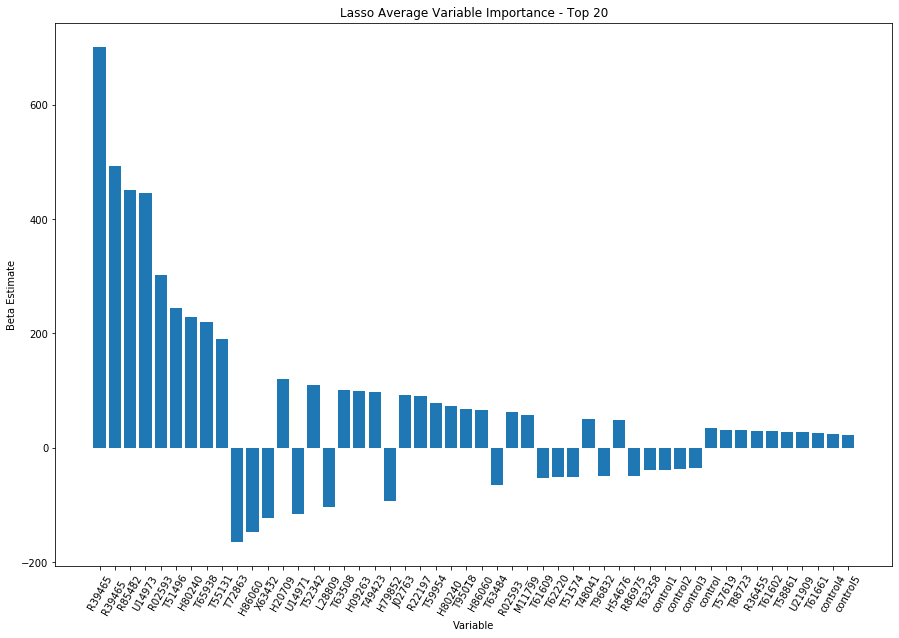

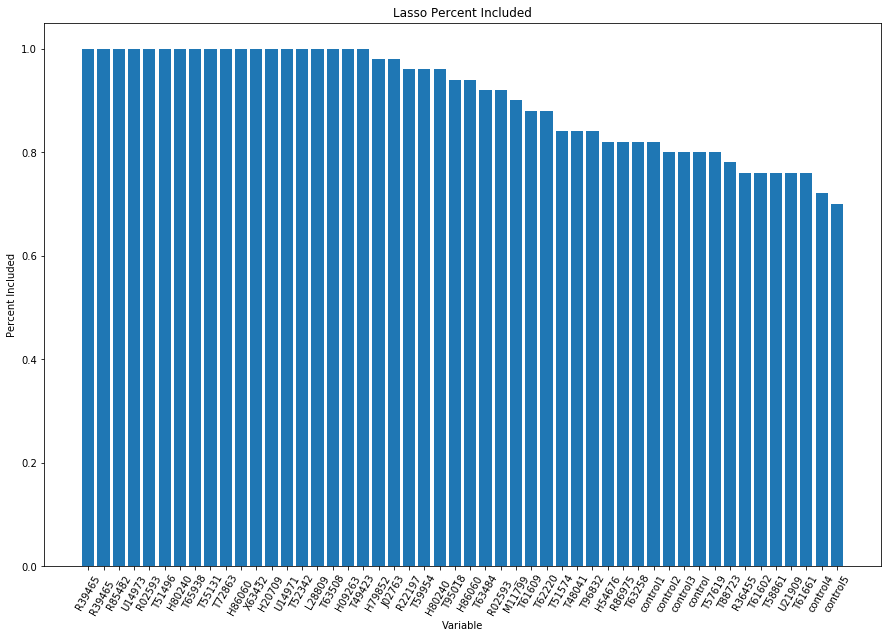

In [20]:
warnings.filterwarnings(action='ignore')
# I tuned the warnings off to increase readabiliity
## You should always read the warnings first and determine whether you are ok ignoring them
stab_analysis(X_train, y_train, alg = 'Lasso', niter = 50, ndisplay = 50, parameters = parameters) 
# This takes a while to run

**What these figures show**

The stability analysis shows that there are 10 predictors that have a large significant correlation with the target gene expression. Around 20 of the predictor genes are included in all of the models. While this may not seem like a large reduction in model complexity - going from 1999 variables to 20 surefire predictors is quite the reduction.

You may want to select the top 20 predictors and perform a further analysis on them.

## Exercise

Now it is your turn! Can you recreate the above analysis with a different target variable? There is no need to include the recreated R plots.

In [46]:
########################
## Pre-processing
########################

## Loading the data and dropping the data
data = pd.read_csv('colon.csv')
data.drop('Unnamed: 0', axis = 1, inplace = True)
data.drop('Class', axis = 1, inplace = True)

## Set the target
target = data['R39465']
data.drop('R39465', axis = 1, inplace = True)

## Splitting the data

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25, random_state=42)
# Since the dataset is small, we are going to make a .25 test size to get more stable results

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train)
X_train.columns = data.columns
X_test = pd.DataFrame(X_test)
X_test.columns = X_test.columns


'''

Note: This is starting our analysis completely over. You could have done:

data['H55933'] = target
target = data['R39465']
data.drop('R39465', axis = 1, inplace = True)

And not had to change data types or scale at all

'''

"\n\nNote: This is starting our analysis completely over. You could have done:\n\ndata['H55933'] = target\ntarget = data['R39465']\ndata.drop('R39465', axis = 1, inplace = True)\n\nAnd not had to change data types or scale at all\n\n"

In [47]:
## Setting up a results dataframe
results = pd.DataFrame(index = ['Lasso'], columns = ['MSE', 'RMSE', 'MAE', 'r2'])

In [1]:
########################
## Lasso
########################

## Fitting the model and making predictions


In [2]:
########################
## Stability Analysis
########################



# Question 2

To explore the other penalized regression models, we will be using the framingham dataset again. It does not suffer from the p>>n issue, but penalized regression may generate more accurate predictions or shed some light on which variables are important.

## Data

We will be using the framingham heart study dataset to predict cholesterol. High cholesterol can cause a dangerous accumulation of cholesterol and other deposits on the walls of your arteries (atherosclerosis). These deposits (plaques) can reduce blood flow through your arteries, which can cause complications, such as chest pain, heart attack, and stroke [https://www.mayoclinic.org/diseases-conditions/high-blood-cholesterol/symptoms-causes/syc-20350800#:~:text=High%20cholesterol%20can%20cause%20a,Chest%20pain.].

**Cleaning the Data**

We will begin by dropping the response variable from week 2 (TenYearCHD). We will then convert all of the binary and categorical responses to the category data type. None of the numeric variables have a large enough range to merit a transformation (like a log transformation) so will be left as is. As only ~9% of the data is missing, we will be dropping the missing variables and doing a complete cases analysis (assuming MCAR). However, for an in-depth analysis, you may want to consider using multiple imputation to fill in the missing values as 5% is normally a good cut value to use for determining whether to drop or impute data (below %5 = impute, 5-25% = impute, more than 25% = drop the variable).

**Scaling the data**

In order for the penalty term to have the same impact on each variable, the data must be scaled. Additionally, if you scale all of the numeric predictors, the magnitude of the betas now act a proxy for important. With all the data on the same scale, higher betas mean higher importance.

We will be using the [StandardScaler function](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), which performs a z-transformation on each of the numeric values. 

$z = \frac{x - \mu}{\sigma}$

You fit the standardscaler object on the training data (getting the $\mu$ and $\sigma\$ values) and then use the fitted object to transform both the training and test data. It is important that you do not fit using the test data - even when you are going to transform the test set. If you do so, this is data leakage and will make it so that identical values will be different after the transformation. For example, 2 in the training set could end up at 1 while 2 in the test set could end up at 1.3.




In [49]:
## Loading the data and dropping the data
data = pd.read_csv('framingham.csv')
data.drop('TenYearCHD', axis = 1, inplace = True)
data = data.dropna()

## Set the target
target = data['totChol']
data.drop('totChol', axis = 1, inplace = True)

## Changing data types
cat_vars = ['male', 'education', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes']

for var in cat_vars:
    data.loc[:,var] = data.loc[:,var].astype('category')
    
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3658 entries, 0 to 4239
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   male             3658 non-null   category
 1   age              3658 non-null   int64   
 2   education        3658 non-null   category
 3   currentSmoker    3658 non-null   category
 4   cigsPerDay       3658 non-null   float64 
 5   BPMeds           3658 non-null   category
 6   prevalentStroke  3658 non-null   category
 7   prevalentHyp     3658 non-null   category
 8   diabetes         3658 non-null   category
 9   sysBP            3658 non-null   float64 
 10  diaBP            3658 non-null   float64 
 11  BMI              3658 non-null   float64 
 12  heartRate        3658 non-null   float64 
 13  glucose          3658 non-null   float64 
dtypes: category(7), float64(6), int64(1)
memory usage: 254.4 KB


In [50]:
data.corr()

,age,cigsPerDay,sysBP,diaBP,BMI,heartRate,glucose
age,1.000000,-0.189295,0.388267,0.208283,0.137511,-0.002722,0.118349
cigsPerDay,-0.189295,1.000000,-0.094781,-0.056746,-0.087395,0.064030,-0.053726
sysBP,0.388267,-0.094781,1.000000,0.786669,0.330917,0.184797,0.134651
diaBP,0.208283,-0.056746,0.786669,1.000000,0.385348,0.178744,0.063540
BMI,0.137511,-0.087395,0.330917,0.385348,1.000000,0.074131,0.083683
heartRate,-0.002722,0.064030,0.184797,0.178744,0.074131,1.000000,0.097074
glucose,0.118349,-0.053726,0.134651,0.063540,0.083683,0.097074,1.000000


In [51]:
## Splitting the data

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.75, random_state=42)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [52]:
num_vars = list(data.columns)
num_vars = [x for x in num_vars if x not in cat_vars]

scaler = StandardScaler()
scaler.fit(X_train.loc[:, num_vars])
X_train.loc[:, num_vars] = scaler.transform(X_train.loc[:, num_vars])
X_test.loc[:,num_vars] = scaler.transform(X_test.loc[:, num_vars])



In [53]:
## Sanity check to make sure we didn't lose any data in the split

X_train.shape[0] + X_test.shape[0] == data.shape[0]

True

In [54]:
## Setting up a results dataframe
results = pd.DataFrame(index = ['Lasso', 'Ridge', 'Elastic'], columns = ['MSE', 'RMSE', 'MAE', 'R2'])

## Lasso

We will be using the lasso function from the scikit-learn package (abbreviated as sklearn). The [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) lets us known that the alpha and random_state parameters are important - with max_iter also being useful.

alpha is the penalty term that is multiplied by the L1 norm. If alpha = 0, then the model is equivalent to a normal linear regression OLS. It defaults to 1. This is a parameter that you want to tune to find the best value for.

random_state creates the psuedo-random numbers that the algorithm uses. It is important to always set a random state (like setting a seed in r) to ensure that your analysis is reproducable. 

max_iter controls the number of iterations. You will sometimes get a warning message that your algorithm did not converge and may need more iterations. Some people choose to ignore this (most people ignore all warnings) while others will increase the max_iter parameter to avoid the warning.

**Cross Validation**

As mentioned above, we will use cross validation to tune the model parameter(s) - which is alpha here. [Grid Search CV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) is a great function to perform this with. It takes in an estimator (like Lasso), a grid of paramaters to test (here just a element dictionary of values for alpha), and the cross splitting strategy. We will use the [repeated kfold function](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedKFold.html) as our strategy - where we will set the number of folds in our cv, a random state, and the number of times to repeat the cv. Additionally, we will set the scoring function to be rmse as it is popular to use and reports values on the same scale as your outcome. 

*Note: n_jobs parameter in gridsearchcv is the number of jobs to run in parallel. -1 will use all the processors. I set it to 3 so that I can still run other scripts/programs on my computer if the model takes a long time to run. These won't, but a neural network can take 8+ hours*

In [56]:
## Fitting the model and making predictions

model = Lasso(random_state = 8) #alpha will be adjusted in the gridsearch
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

clf = GridSearchCV(model, parameters, cv = cv, n_jobs=3, scoring = 'neg_root_mean_squared_error')

clf.fit(X=X_train, y=y_train)
lasso_model = clf.best_estimator_

print('The best alpha value is {}'.format(clf.best_params_['alpha']))

y_pred = lasso_model.predict(X_test)

num_pred= sum(lasso_model.coef_ != 0)
results = get_reg_results(y_test, y_pred, results, 'Lasso')




The best alpha value is 0.8


In [64]:
results

,MSE,RMSE,MAE,R2
Lasso,1755.44,41.898,32.332,0.089
Ridge,NaN,NaN,NaN,NaN
Elastic,NaN,NaN,NaN,NaN


In [57]:
lasso_df = pd.DataFrame({'variable': list(X_train.columns), 'estimate': lasso_model.coef_})
lasso_df = lasso_df.sort_values('estimate')
lasso_df

,variable,estimate
0,male,-3.010760
3,currentSmoker,-0.000000
4,cigsPerDay,0.000000
5,BPMeds,0.000000
6,prevalentStroke,-0.000000
7,prevalentHyp,0.000000
8,diabetes,-0.000000
13,glucose,-0.000000
2,education,0.079068
10,diaBP,0.509039


In [58]:
lasso_df[lasso_df['estimate'] == 0]

,variable,estimate
3,currentSmoker,-0.0
4,cigsPerDay,0.0
5,BPMeds,0.0
6,prevalentStroke,-0.0
7,prevalentHyp,0.0
8,diabetes,-0.0
13,glucose,-0.0


In [59]:
lasso_df[lasso_df['estimate'] != 0]

,variable,estimate
0,male,-3.010760
2,education,0.079068
10,diaBP,0.509039
11,BMI,2.243794
12,heartRate,3.254659
9,sysBP,4.333236
1,age,10.477151


#### R equivalent plots

In [60]:
## Creating the data to plot

lasso_reg = Lasso(alpha=0,random_state = 8)
lasso_reg.fit(X_train, y_train)
lasso_df = pd.DataFrame({'variable': list(X_train.columns), 'estimate': lasso_reg.coef_})
lasso_train_pred = []
lasso_test_pred = []

# iterate lambdas
for i,alpha in enumerate(np.arange(0, 5, .1)):
    # training
    lasso_mod = Lasso(alpha=alpha, random_state = i)
    lasso_mod.fit(X_train, y_train)
    var_name = 'estimate' + str(alpha)
    lasso_df[var_name] = lasso_mod.coef_
    lasso_train_pred.append(lasso_mod.predict(X_train))
    lasso_test_pred.append(lasso_mod.predict(X_test))
    

/Users/thomas/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  after removing the cwd from sys.path.
/Users/thomas/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/thomas/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 793148.6015714279, tolerance: 182.11528807439828
  positive)
/Users/thomas/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  del sys.path[0]
/Users/thomas/miniconda3/lib/python3.7/site-pack

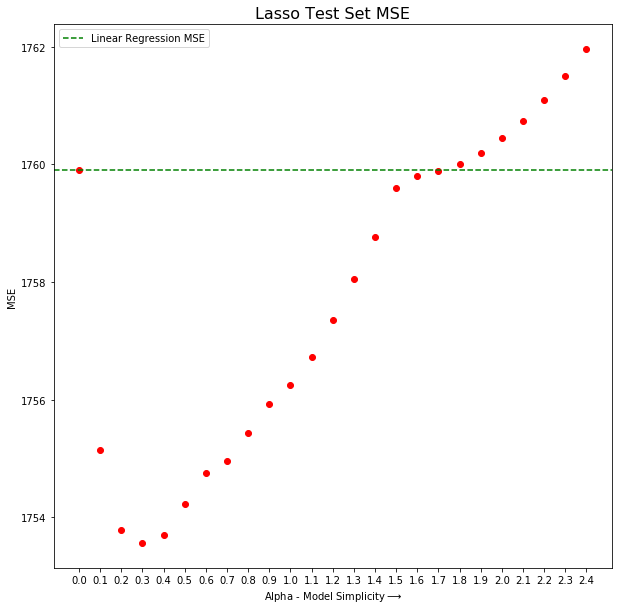

In [61]:
## Test MSE
xlabels = [round(x,2) for x in np.arange(0, 5, .1)]
lasso_mse_test = [mean_squared_error(y_test, p) for p in lasso_test_pred]
ols_pred = lasso_reg.predict(X_test)
ols_mse = mean_squared_error(y_test, ols_pred)

# plot mse
plt.figure(figsize = (10,10))
plt.plot(lasso_mse_test[:25], 'ro')
plt.axhline(y=ols_mse, color='g', linestyle='--', label = 'Linear Regression MSE')
plt.title("Lasso Test Set MSE", fontsize=16)
plt.xlabel("Alpha - Model Simplicity$\longrightarrow$")
plt.xticks(range(25), labels = xlabels[:25])
plt.ylabel("MSE")
_ = plt.legend(loc = 'upper left')

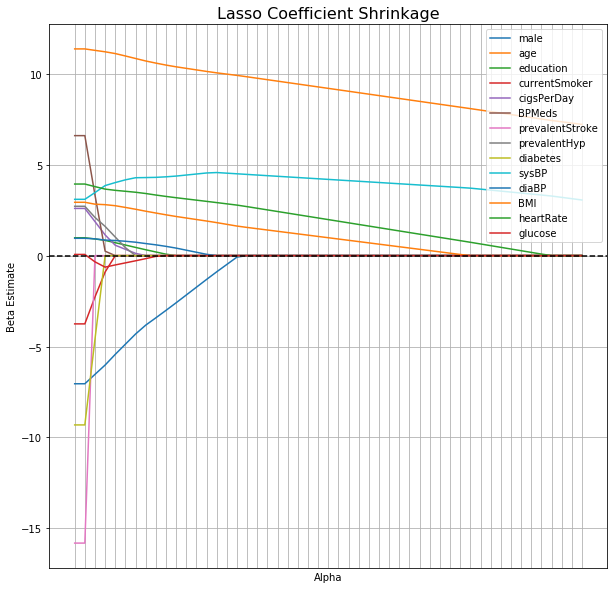

In [62]:
## Coefficient Shrinkage Plot

fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(lasso_df.T.iloc[1:, :])
ax.axhline(y=0, color='black', linestyle='--')
ax.set_xlabel("Alpha")
ax.set_ylabel("Beta Estimate")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.set_title("Lasso Coefficient Shrinkage", fontsize=16)
ax.legend(loc = 'upper right', labels=lasso_df['variable'])
ax.grid(True)

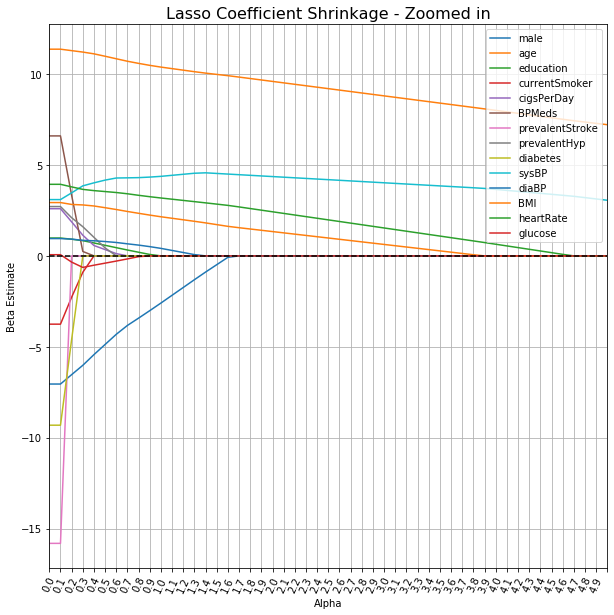

In [63]:
xlabels = [round(x,2) for x in np.arange(0, 5, .1)]
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(lasso_df.T.iloc[1:, :])
ax.axhline(y=0, color='black', linestyle='--')
ax.set_xlabel("Alpha")
ax.set_xlim([0,50])
ax.set_xticklabels(xlabels)
plt.xticks(rotation = 65)
ax.set_ylabel("Beta Estimate")
ax.set_title("Lasso Coefficient Shrinkage - Zoomed in", fontsize=16)
ax.legend(loc = 'upper right', labels=lasso_df['variable'])
ax.grid(True)

**Looking at the plots**

From the MSE plot, we can see that adding bias to the model (and reducing the complexity) does improve model performance. 

From the shrinkage plot, we can see that age and being male are the most important features - as they are the last two to be shrunk to zero and last much longer than the rest. Diabetes looks to be the least important as it is the first to be shrunk. However, it is important to remember the random element of lasso that makes it so we cannot draw strong analysis about feature importance without doing a stability analysis.

#### Stability Analysis

There is no prebuilt stability analysis function for penalized regression analysis, so we will make our own - found in the functions section at the top of the notebook. To do so, we will create the same model as above 100 times while storing the beta coefficients from each model. We will then average the coefficients across the model - giving their average importance. For this lasso section only, we will also look at what the percent of the time a coefficient is included in the model.

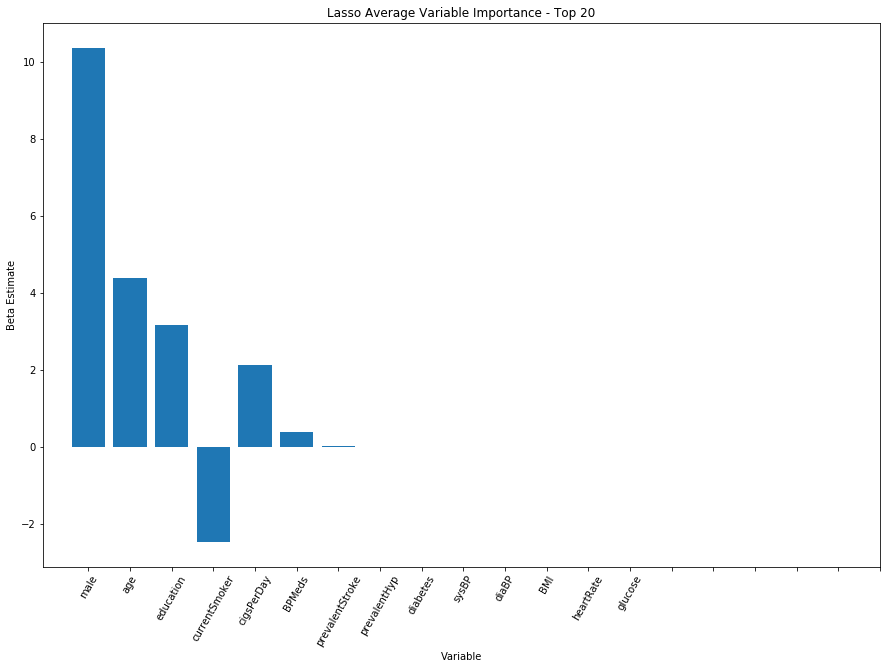

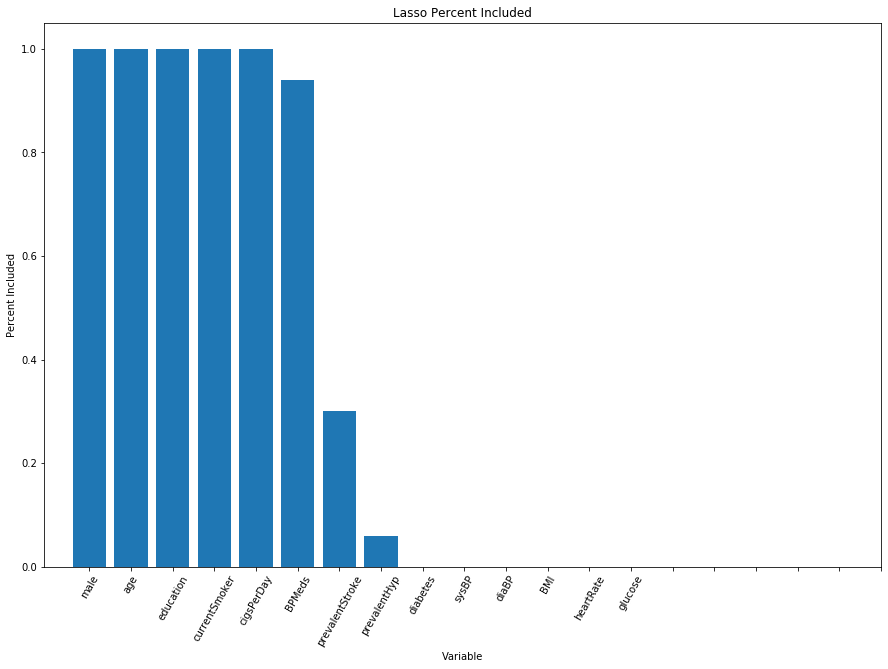

In [41]:
warnings.filterwarnings(action='ignore')
# I tuned the warnings off to increase readabiliity
## You should always read the warnings first and determine whether you are ok ignoring them
stab_analysis(X_train, y_train, alg = 'Lasso', parameters = parameters, niter = 50) # This takes a while to run

**What these figures show**

After performing the stability analysis, we can see that 5 predictors where included in the best model every time with six variables being never selected and unimportant to the model. Looking at the average betas, sex is the most important followed by age and education.

## Ridge Regression

We will be using the ridge function from the scikit-learn package (abbreviated as sklearn). The [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) lets us known that the alpha,  max_iter and random_state parameters are important - just like the lasso function.

Just like for lasso:

alpha is the penalty term that is multiplied by the L1 norm. If alpha = 0, then the model is equivalent to a normal linear regression OLS. It defaults to 1. This is a parameter that you want to tune to find the best value for.

random_state creates the psuedo-random numbers that the algorithm uses. It is important to always set a random state (like setting a seed in r) to ensure that your analysis is reproducable. 

max_iter controls the number of iterations. You will sometimes get a warning message that your algorithm did not converge and may need more iterations. Some people choose to ignore this (most people ignore all warnings) while others will increase the max_iter parameter to avoid the warning.




In [66]:
## Fitting the model and making predictions

model = Ridge(random_state = 8) #alpha will be adjusted in the gridsearch
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

clf = GridSearchCV(model, parameters, cv = cv, n_jobs=3, scoring = 'neg_root_mean_squared_error')

clf.fit(X=X_train, y=y_train)
Ridge_model = clf.best_estimator_

print('The best alpha value is {}'.format(clf.best_params_['alpha']))

y_pred = Ridge_model.predict(X_test)


results = get_reg_results(y_test, y_pred, results, 'Ridge')

results

The best alpha value is 4.9


,MSE,RMSE,MAE,R2
Lasso,1755.44,41.898,32.332,0.089
Ridge,1757.51,41.923,32.326,0.088
Elastic,NaN,NaN,NaN,NaN


The range that you iterate over for your alpha values may stop you from finding the optimal solution. Below, we expand our range to 0-115 and find that using an alpha of 114 generates a marginally lower RMSE. Since the difference is so small, we will use the original range for the stability analysis for computational reasons (less models to compare).

In [67]:
model = Ridge(random_state = 8) #alpha will be adjusted in the gridsearch
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
new_parameters = {'alpha':np.arange(0, 115, 1)}
clf = GridSearchCV(model, new_parameters, cv = cv, n_jobs=3, scoring = 'neg_root_mean_squared_error')

clf.fit(X=X_train, y=y_train)
Ridge_model = clf.best_estimator_

print('The best alpha value is {}'.format(clf.best_params_['alpha']))

y_pred = Ridge_model.predict(X_test)


results = get_reg_results(y_test, y_pred, results, 'Ridge')

results

The best alpha value is 114


,MSE,RMSE,MAE,R2
Lasso,1755.44,41.898,32.332,0.089
Ridge,1752.47,41.863,32.296,0.091
Elastic,NaN,NaN,NaN,NaN


#### R equivalent plots

In [68]:
## Creating the data to plot

Ridge_reg = Ridge(alpha=0, random_state = 8)
Ridge_reg.fit(X_train, y_train)
Ridge_df = pd.DataFrame({'variable': list(X_train.columns), 'estimate': Ridge_reg.coef_})
Ridge_train_pred = []
Ridge_test_pred = []

# iterate lambdas
for i, alpha in enumerate(np.arange(0, 5, .1)):
    # training
    Ridge_mod = Ridge(alpha=alpha, random_state = i)
    Ridge_mod.fit(X_train, y_train)
    var_name = 'estimate' + str(alpha)
    Ridge_df[var_name] = Ridge_mod.coef_
    Ridge_train_pred.append(Ridge_mod.predict(X_train))
    Ridge_test_pred.append(Ridge_mod.predict(X_test))
    

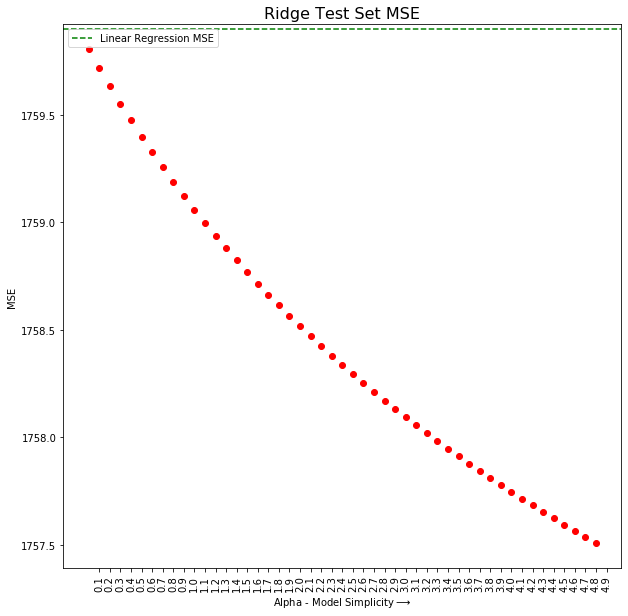

In [69]:
## Test MSE
xlabels = [round(x,2) for x in np.arange(0, 5, .1)]
Ridge_mse_test = [mean_squared_error(y_test, p) for p in Ridge_test_pred]
ols_pred = Ridge_reg.predict(X_test)
ols_mse = mean_squared_error(y_test, ols_pred)

# plot mse
plt.figure(figsize = (10,10))
plt.plot(Ridge_mse_test[1:50], 'ro')
plt.axhline(y=ols_mse, color='g', linestyle='--', label = 'Linear Regression MSE')
plt.title("Ridge Test Set MSE", fontsize=16)
plt.xlabel("Alpha - Model Simplicity$\longrightarrow$")
plt.xticks(range(1,50), labels = xlabels[1:50], rotation = 90)
plt.ylabel("MSE")
_ = plt.legend(loc = 'upper left')

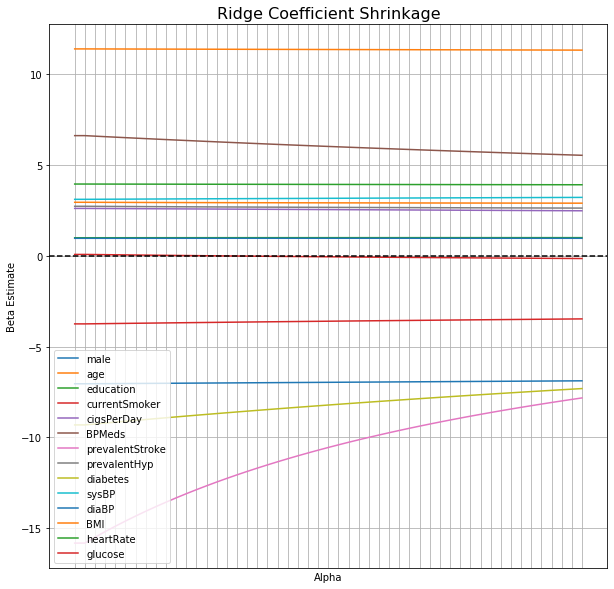

In [70]:
## Coefficient Shrinkage Plot

fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(Ridge_df.T.iloc[1:, :])
ax.axhline(y=0, color='black', linestyle='--')
ax.set_xlabel("Alpha")
ax.set_ylabel("Beta Estimate")

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.set_title("Ridge Coefficient Shrinkage", fontsize=16)
ax.legend(loc = 'best', labels=Ridge_df['variable'])
ax.grid(True)

#### Looking at the plots

As we can see from the RMSE plot that adding in bias again improves our predictive power. In the previous figures, we were able to see where the error starts to increase again. However, here we found that 114 was the alpha corresponding to the global lowest error value. For ease of plotting visualization, the range cuts short well before that. Again, use R if you want the best version of these plots!

The coefficient shrinkage plot shows that while none of the coefficents are shrunk to 0 (as it is not lasso), they magnitude of the betas does decrease as alpha increases -- particularly for the harmful effect of having prevelance of stroke.

#### Stability analysis

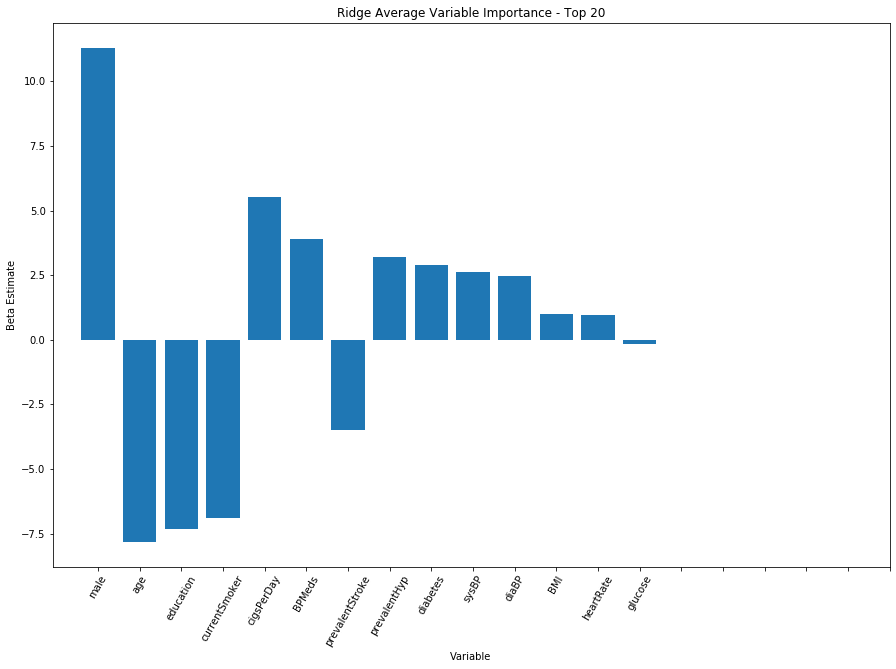

In [47]:
warnings.filterwarnings(action='ignore')
stab_analysis(X_train, y_train ,alg = 'Ridge', parameters = parameters, niter = 50) # This takes a while to run

**What this figure shows**

The stability analysis shows that sex is still the most important predictors, while age and education are now found to be protective. Notice that all of the predictors have an estimate now - since they are all selected in all of the models. 

# Elastic Net

We will be using the elasticnet function from the scikit-learn package (abbreviated as sklearn). The [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) shows that the same parameters are important as lasso and ridge - with one new one.

l1_ratio - determines the weight between using the l1 and l2 normed penalites. l1 of 1 = alpha, l1 of 0 = ridge, and l1 of 0.5 is an exact split. *Note: This l1_ratio term is the equivalent to the alpha parameter in glmnet (somewhat confusingly).*

In [71]:
## Fitting the model and making predictions

model = ElasticNet(random_state = 8) #alpha will be adjusted in the gridsearch
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

clf = GridSearchCV(model, params, cv = cv, n_jobs=3, scoring = 'neg_root_mean_squared_error')

clf.fit(X=X_train, y=y_train)
ElasticNet_model = clf.best_estimator_

print('The Elastic Net best alpha value is {} and best l1 ratio is {}'.format(clf.best_params_['alpha'], clf.best_params_['l1_ratio']))

y_pred = ElasticNet_model.predict(X_test)


results = get_reg_results(y_test, y_pred, results, 'Elastic')
results

The Elastic Net best alpha value is 0.8 and best l1 ratio is 0.9


,MSE,RMSE,MAE,R2
Lasso,1755.44,41.898,32.332,0.089
Ridge,1752.47,41.863,32.296,0.091
Elastic,1754.45,41.886,32.326,0.09


#### Creating the equivalent plots

As we are iterating over two parameters now (alpha and l1 ratio) it is a little bit more difficult. We will plot the error curves for each l1 ratio tested across all alpha values tested - which should hopefully demonstrate that the different ratios have consistent relative performance. Do remember that just because a ratio (such as .2) might be the best at every alpha level here, it will not always be the best ratio and should always be tuned. Next, we will hold the l1_ratio at 0.5 and look at the error curve to see if increasing alpha outperforms a standard linear regression. Lastly, we will look at the coefficent shrinkage of the 0.5 l1 ratio model (it would be too cluttered to look at all of them).

Since we can't visualize the shrinkage plot very well, it is even more important to do the stability analysis to generate inferences over feature importance.

In [72]:
## Creating the data to plot

ElasticNet_reg = ElasticNet(alpha=0, random_state = 8)
ElasticNet_reg.fit(X_train, y_train)
ElasticNet_df = pd.DataFrame({'variable': list(X_train.columns), 'estimate': ElasticNet_reg.coef_})
ElasticNet_train_pred = []
ElasticNet_test_pred = []
xlabels = []

# iterate lambdas

i = 0
for alpha in np.arange(0, 7, .1):
    for ratio in np.arange(0.1,1,.1):
        # training
        ElasticNet_mod = ElasticNet(alpha=alpha, l1_ratio = ratio, random_state = i)
        ElasticNet_mod.fit(X_train, y_train)
        var_name = 'estimate' + str(alpha)
        ElasticNet_df[var_name] = ElasticNet_mod.coef_
        ElasticNet_train_pred.append(ElasticNet_mod.predict(X_train))
        ElasticNet_test_pred.append(ElasticNet_mod.predict(X_test))
        i += 1
        xlabels.append('a' + str(alpha) + '_r' + str(ratio))



/Users/thomas/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  after removing the cwd from sys.path.
/Users/thomas/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/thomas/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 793148.6015714279, tolerance: 182.11528807439828
  positive)
/Users/thomas/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/Users/thomas/miniconda3/lib/python3.7/site-packages/sklearn/linea

In [73]:
elastic_df = pd.DataFrame(index = np.arange(0, 7, .1), columns = np.arange(0.1,1,.1))

i = 0
for idx, alpha in enumerate(np.arange(0, 7, .1)):
    for col, ratio in enumerate(np.arange(0.1,1,.1)):
        # training
        elastic_df.iloc[idx, col] = mean_squared_error(y_test, ElasticNet_test_pred[i-1])
        i += 1

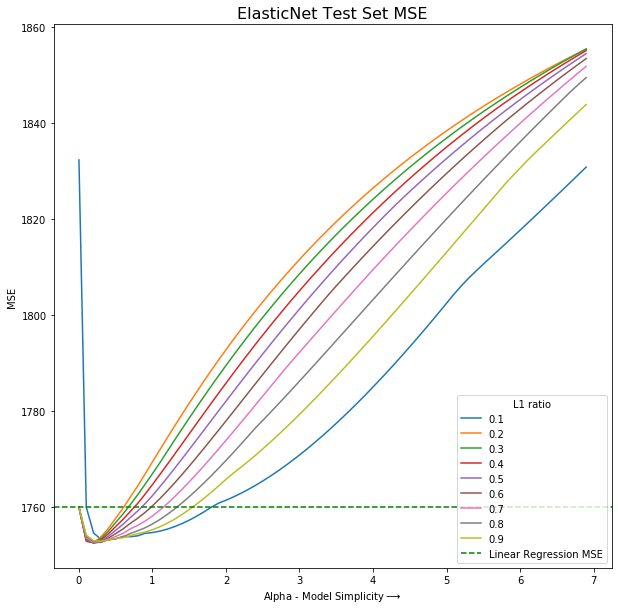

In [74]:
## Test MSE
xlabels = [round(x,4) for x in np.arange(0, 7, .1)]
ols_pred = ElasticNet_reg.predict(X_test)
ols_mse = mean_squared_error(y_test, ols_pred)

# plot mse
plt.figure(figsize = (10,10))
for i in range(elastic_df.shape[1]):
    plt.plot(elastic_df.iloc[:,i], label = round(elastic_df.columns[i],4))
plt.axhline(y=ols_mse, color='g', linestyle='--', label = 'Linear Regression MSE')
plt.title("ElasticNet Test Set MSE", fontsize=16)
plt.xlabel("Alpha - Model Simplicity$\longrightarrow$")
plt.ylabel("MSE")
_ = plt.legend(loc = 'best', title = 'L1 ratio')

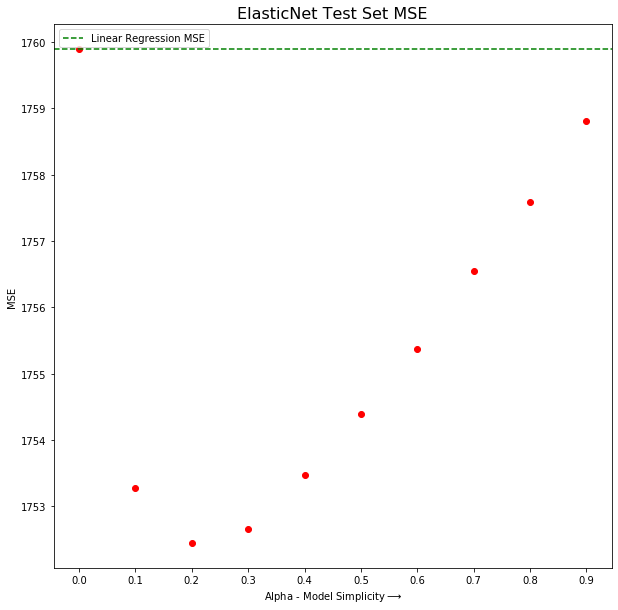

In [52]:
## Creating the data to plot

ElasticNet_reg = ElasticNet(alpha=0, random_state = 8)
ElasticNet_reg.fit(X_train, y_train)
ElasticNet_df = pd.DataFrame({'variable': list(X_train.columns), 'estimate': ElasticNet_reg.coef_})
ElasticNet_train_pred = []
ElasticNet_test_pred = []
xlabels = []

# iterate lambdas

i = 0
ratio = 0.5
for alpha in np.arange(0, 7, .1):
    # training
    ElasticNet_mod = ElasticNet(alpha=alpha, l1_ratio = ratio, random_state = i)
    ElasticNet_mod.fit(X_train, y_train)
    var_name = 'estimate' + str(alpha)
    ElasticNet_df[var_name] = ElasticNet_mod.coef_
    ElasticNet_train_pred.append(ElasticNet_mod.predict(X_train))
    ElasticNet_test_pred.append(ElasticNet_mod.predict(X_test))
    i += 1
    xlabels.append('a' + str(alpha) + '_r' + str(ratio))

## Test MSE
xlabels = [round(x,4) for x in np.arange(0, 7, .1)]
ElasticNet_mse_test = [mean_squared_error(y_test, p) for p in ElasticNet_test_pred]
ols_pred = ElasticNet_reg.predict(X_test)
ols_mse = mean_squared_error(y_test, ols_pred)

# plot mse
plt.figure(figsize = (10,10))
plt.plot(ElasticNet_mse_test[:10], 'ro')
plt.axhline(y=ols_mse, color='g', linestyle='--', label = 'Linear Regression MSE')
plt.title("ElasticNet Test Set MSE", fontsize=16)
plt.xlabel("Alpha - Model Simplicity$\longrightarrow$")
plt.xticks(range(10), labels = xlabels[:10])
plt.ylabel("MSE")
_ = plt.legend(loc = 'upper left')

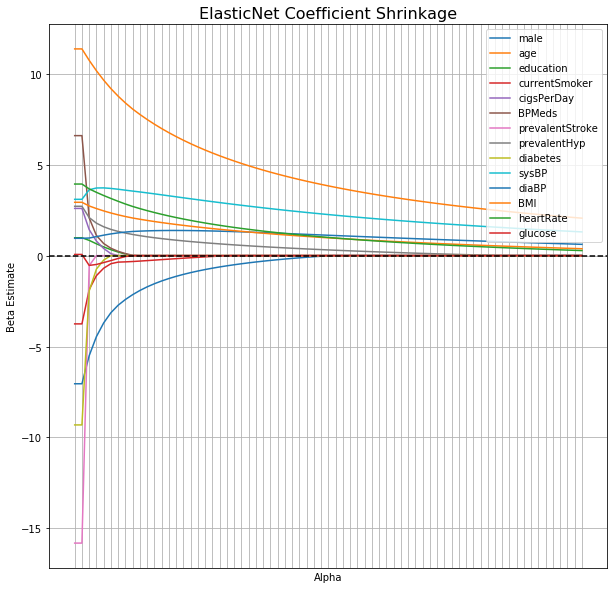

In [57]:
## Coefficient Shrinkage Plot

fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(ElasticNet_df.T.iloc[1:, :])
ax.axhline(y=0, color='black', linestyle='--')
ax.set_xlabel("Alpha")
ax.set_ylabel("Beta Estimate")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.set_title("ElasticNet Coefficient Shrinkage", fontsize=16)
ax.legend(loc = 'upper right', labels=ElasticNet_df['variable'])
ax.grid(True)

#### Looking at the plots

As we can see from the first RMSE plot, adding bias increases the predictive power for every level of the l1 ratio.

Using an l1 ratio of 0.5 (the second RMSE plot), we can see that the best alpha is 0.2. 

From the coefficient shrinkage plot, we can see that while the coefficients are not shrunk all the way to 0 (they get really close!!), the betas are shrunk more drastically than the ridge regression.

#### Stability analysis

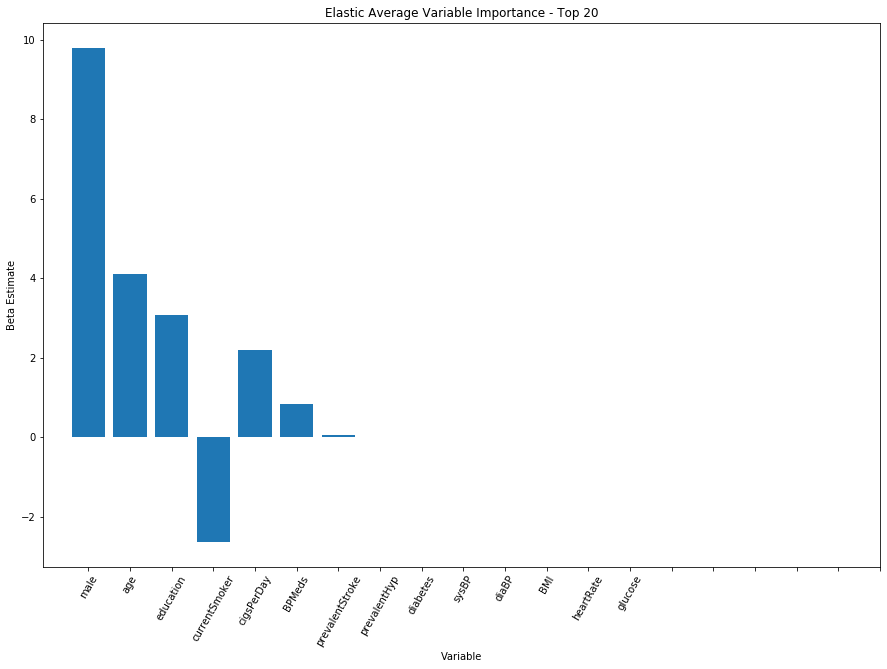

In [58]:
warnings.filterwarnings(action='ignore')


stab_analysis(X_train, y_train, alg = 'Elastic', niter = 5, parameters = params) # This takes a while to run
# niter lowered due to the long amount of time this takes to run

**What this figure shows**

This figure is almost exactly the same as the lasso plot. The same variables are shrunk to have coefficients of 0 while the top 5 predictors have the same order, direction and magnitude.

Since all two of our methods gave the same results about feature importance, we can confidently conclude that being a male and your age are the most important predictors.

Why is currentsmoker negative while cigsPerDay is positive? A full statistical anlaysis would need to investigate and address this. A guess would be that since current smoker is binary, it changes the regression intercept. Given the large decrease in the intercept, the number of cigs smoked can make the slope more steep - so it may just be a math quirk rather than an actually preventative measure. Again, figuring out the exact reason is outside of the scope of this illustrative example but is imperative for a sound and robust analysis.

In [75]:
results

,MSE,RMSE,MAE,R2
Lasso,1755.44,41.898,32.332,0.089
Ridge,1752.47,41.863,32.296,0.091
Elastic,1754.45,41.886,32.326,0.09


**Looking at the results**

We can see that there is a negliable difference between the model performance. Sometimes there will be a large difference in model performance - suggesting which model to select. Other times, the shape of the data (p > n requires lasso), correlation structure (elastic net > lasso for correlated), or prior knowledge of the phenomena (lots of weak effects = ridge) will help you decide which to pick. Here, I would select the best performing model with the fewest predictors (lasso or elastic net).

## Exercise

Now it is your turn! Can you recreate the above analysis with a different target variable - such as bmi? There is no need to include the recreated R plots.

**Note: If you want to use systolic or diastolic blood pressure, you should remove one of them and possibly heart rate. Additionally, if you are predicting heart rate, you might want to remove both blood pressure measures. The blood pressure measurements are mearly different scales of the same physicoloigcal process. Heart rate may be too heavily tied to blood pressure to use one as a predictor of another - you would have to research whether they are merely correlated or if there is a mechanistic relationship between the two.**  

In [60]:
data.columns

Index(['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'sysBP', 'diaBP', 'BMI',
       'heartRate', 'glucose'],
      dtype='object')

In [61]:
########################
## Pre-processing
########################

## Loading the data and dropping the data
data = pd.read_csv('framingham.csv')
data.drop('TenYearCHD', axis = 1, inplace = True)
data = data.dropna()

## Set the target
target = data['BMI']
data.drop('BMI', axis = 1, inplace = True)

## Changing data types
cat_vars = ['male', 'education', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes']

for var in cat_vars:
    data.loc[:,var] = data.loc[:,var].astype('category')
    

## Splitting the data

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

## Scaling the data

num_vars = list(data.columns)
num_vars = [x for x in num_vars if x not in cat_vars]
num_vars

scaler = StandardScaler()
scaler.fit(X_train.loc[:, num_vars])
X_train.loc[:, num_vars] = scaler.transform(X_train.loc[:, num_vars])
X_test.loc[:,num_vars] = scaler.transform(X_test.loc[:, num_vars])

'''

Note: This is starting our analysis completely over. You could have done:

data['Chol'] = target
target = data['bmi']
data.drop('bmi', axis = 1, inplace = True)

And not had to change data types or scale at all

'''

"\n\nNote: This is starting our analysis completely over. You could have done:\n\ndata['Chol'] = target\ntarget = data['bmi']\ndata.drop('bmi', axis = 1, inplace = True)\n\nAnd not had to change data types or scale at all\n\n"

In [62]:
## Setting up a results dataframe
results = pd.DataFrame(index = ['Lasso', 'Ridge', 'Elastic'], columns = ['MSE', 'RMSE', 'MAE', 'R2'])

In [3]:
########################
## Lasso
########################

## Fitting the model and making predictions


########################
## Ridge Regression
########################

## Fitting the model and making predictions



########################
## Elastic Net
########################

## Fitting the model and making predictions



########################
## Stability Analysis
########################



## Extra Resources

1. Penalized Classification - https://towardsdatascience.com/penalized-regression-with-classification-f60bc663e8dc
2. Want more math? - http://faculty.washington.edu/yenchic/18W_425/Lec11_Reg03.pdf
3. Basic R example - http://www.sthda.com/english/articles/37-model-selection-essentials-in-r/153-penalized-regression-essentials-ridge-lasso-elastic-net/ **Note you should refer to your excellent comp epi practicals for how to use these methods properly in R
4. Detailed video on the math of the three methods https://www.youtube.com/watch?v=KIoz_aa1ed4
5. Bias vs Variance https://www.youtube.com/watch?v=EuBBz3bI-aA
6. Datacamp tutorial https://www.datacamp.com/community/tutorials/tutorial-ridge-lasso-elastic-net